### orbit of a planet in the potential of a star

In [34]:
import sys
import os
sys.path.append(os.path.relpath('/Users/edoardo/AstroCosmoComputational/Students'))

In [35]:
import numpy as np
from pyACC import calculus
from pyACC import cosmology

In [36]:
from scipy.interpolate import interp2d
import matplotlib.pyplot as plt

In [37]:
G=1

In [38]:
def potential(m1, r0):
    return lambda r: -G*m1/np.linalg.norm(r0-r)


In [39]:
pos1= np.array([-10,0,0])
pos2= np.array([10,0,0])

In [48]:
x,y = np.meshgrid(np.arange(-10,10,1), np.arange(-10,10,1), indexing='xy')

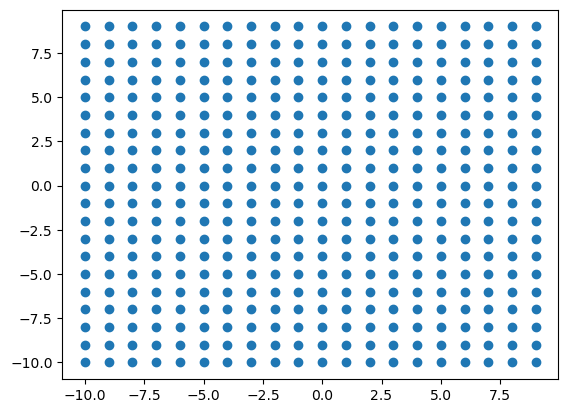

In [49]:
plt.scatter(x,y, marker='o')

In [ ]:
plt.plot(potential)

In [ ]:
V = interp2d(x, y, )